# Detección de tópicos por tweet en threads

## Importacion de librerias y definicion de funciones

Se importan las librerias necesarias y se definen las funciones para tokenizar, lemmatizar y para preparar el texto para el LDA.

En la tokenizacion se eliminan los hashtags y los usuarios citados

In [40]:
import os
import pymongo
import re
import random
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint

import spacy
from spacy.lang.en import English
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer


import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel

import pickle

import pyLDAvis
import pyLDAvis.gensim

nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

In [2]:
#conexion mongo
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["twitter-memoria"]

csv_all = mydb["csv_all"]

In [3]:
spacy.load('en')
parser = English()
nltk.download('wordnet')

def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)



def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 3]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    #indexes = [m.span() for m in re.finditer(r'#\w+',text,flags=re.IGNORECASE)]
    #for start,end in indexes:
    #    tokens.merge(start_idx=start,end_idx=end)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            continue
        elif token.orth_.startswith('#'):
            #lda_tokens.append(token)
            continue
        elif token.orth_.startswith('@'):
            continue
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

tokenize("esto es un #ejemplo @usuario")


['esto', 'es', 'un', 'ejemplo']

## Importacion de archivos

Se cargan los archivos csv y se agrupan los tweets por threads, para luego crear un diccionario de tweets por cada thread (thread 1 : tweet1, tweet2...)

In [7]:
string = '\n'

hilos_ref = []
all_hilos = []
tweets = csv_all.find({})

threads1 = {}
threads2 = {}
threads3 = {}
threads4 = {}
threads5 = {}
kthreads1 = {}
kthreads2 = {}
kthreads3 = {}
kthreads4 = {}
kthreads5 = {}
hilo_Tthreads = {}

for tweet in tweets:
    if tweet["hilo_ref"] not in hilos_ref:
        hilos_ref.append(tweet["hilo_ref"])

for hilo in hilos_ref:
    tweets_hilo = csv_all.find({"hilo_ref": hilo})
    lista_aux_hilos = []
    csv = ""
    for tweet_aux in tweets_hilo:
        lista_aux_hilos.append(tweet_aux["text"])
        csv = tweet_aux["csv"]
        hilo_csv = tweet_aux["hilo"]
    
    if csv == "csv1":
        threads1[hilo_csv] = lista_aux_hilos
        kthreads1[hilo_csv] = string.join(lista_aux_hilos)
    elif csv == "csv2":
        threads2[hilo_csv] = lista_aux_hilos
        kthreads2[hilo_csv] = string.join(lista_aux_hilos)
    elif csv == "csv3":
        threads3[hilo_csv] = lista_aux_hilos
        kthreads3[hilo_csv] = string.join(lista_aux_hilos)
    elif csv == "csv4":
        threads4[hilo_csv] = lista_aux_hilos
        kthreads4[hilo_csv] = string.join(lista_aux_hilos)
    elif csv == "csv5":
        threads5[hilo_csv] = lista_aux_hilos
        kthreads5[hilo_csv] = string.join(lista_aux_hilos)
        
    hilo_Tthreads[hilo_csv] = string.join(lista_aux_hilos)
        
Tthreads1 = list(kthreads1.values())
Tthreads2 = list(kthreads2.values())
Tthreads3 = list(kthreads3.values())
Tthreads4 = list(kthreads4.values())
Tthreads5 = list(kthreads5.values())


## Megacorpus

Como tercera alternativa de análisis, se decide unir todos los threads que se tienen en un megacorpus, por lo que se utilizan cada thread de todos los archivos como un documento, luego se detectan los topicos presentes en los aproximadamente 500 documentos entregados.

In [8]:
megatexto = Tthreads1+Tthreads2+Tthreads3+Tthreads4+Tthreads5

In [9]:

NUM_TOPICS = 20
NUM_WORDS = 10


C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [10]:
THIS_FOLDER = os.getcwd()
threads_leer = megatexto
carpeta_guardar = "mega"

#Poblar text_data

camino = os.path.join(THIS_FOLDER, carpeta_guardar)
text_data = []
documentos = []
dictionary = []
corpus = []
documentos = threads_leer

#print(documentos)

for line in documentos:
    #print(line)
    tokens = prepare_text_for_lda(line)
    if random.random() > .009:
        #print(tokens)
        text_data.append(tokens)
        
NDIC = camino+"\\t_dictionary1.gensim"
NMOD = camino+"\\t_model1.gensim"
NCOR = camino+"\\t_corpus1.pkl"
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]
pickle.dump(corpus, open(NCOR, 'wb'))
dictionary.save(NDIC)

ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save(NMOD)
topics = ldamodel.print_topics(num_words=NUM_WORDS)
for topic in topics:
    print(topic)

(0, '0.014*"qanon" + 0.011*"people" + 0.006*"make" + 0.005*"know" + 0.005*"like" + 0.005*"would" + 0.004*"time" + 0.004*"post" + 0.004*"need" + 0.004*"take"')
(1, '0.010*"iran" + 0.009*"iraq" + 0.006*"leave" + 0.006*"ecodescom" + 0.006*"brexit" + 0.006*"election" + 0.006*"windsor" + 0.005*"vote" + 0.005*"uranium" + 0.005*"prince"')
(2, '0.022*"trump" + 0.008*"know" + 0.008*"russia" + 0.007*"would" + 0.006*"clinton" + 0.005*"russian" + 0.004*"campaign" + 0.004*"comey" + 0.004*"company" + 0.004*"say"')
(3, '0.021*"qanon" + 0.019*"thestorm" + 0.018*"greatawakening" + 0.009*"internetbillofrights" + 0.006*"gitmo" + 0.005*"oigreport" + 0.005*"trump" + 0.005*"know" + 0.004*"take" + 0.004*"think"')
(4, '0.014*"vote" + 0.009*"2018" + 0.009*"candidate" + 0.009*"democratic" + 0.006*"georgia" + 0.004*"register" + 0.004*"manafort" + 0.004*"district" + 0.004*"need" + 0.004*"november"')
(5, '0.018*"trump" + 0.012*"pour" + 0.009*"mueller" + 0.008*"dans" + 0.007*"avec" + 0.005*"président" + 0.005*"cont

### Analisis de resultados de megacorpus

Luego de detectar los topicos, se clasificarán los threads de un archivo según los tópicos obtenidos.

In [13]:
for hilo in Tthreads1:
    hilito = prepare_text_for_lda(hilo)
    hilito_bow = dictionary.doc2bow(hilito)
    """hilo_hilo = [key for key, value in hilo_Tthreads.iteritems() if value == hilo][0]
    print(hilo_hilo)
    """
    print(hilo)
    print(ldamodel.get_document_topics(hilito_bow))
    

5. Create a path to a green card for E-2 investors. Include any children brought here before age 21.
6. Let's really make a 10 year law: provisional green cards.
7. Direct DHS to allow people to take the steps to correct their immigration status.
8. Penalties besides deportation.
24. Vote out elected officials with close ties to nativist, white nationalist, or fearmongering groups such as FAIR, CIS, NumbersUSA, US Inc., KKK, VDare, etc.
25. Give immig judges true independence, more support staff.
26. Backlog relief for India, China, Philippines, Mexico.
15. Expand ESL instruction.
16. Create state Offices of New Americans.
17. Make real use of S visas to take down cartels.
18. Make filing for citizenship free or almost free.
19. Create path to green card for longterm TPS holders.
20. Recognize "deportees" as a group for asylum.
So much can be done. Yet we're stuck between a border wall and DACA. And gutting protections for 90% of the currently undocumented. 

They've been gutting it fo

I'm of the belief that the most successful politicians are the ones who will listen to the experts in whatever the respective field may be. Want to craft the best policy to deal with the opioid epidemic? Talk to the experts in that field. Don't shut them down.
[(3, 0.99251974)]
Pruitt is a danger to the public, yet is losing in the courts while conning @realDonaldTrump into saving his job...all while defying &amp; insulting his boss. Perhaps Trump is the empty vessel Scott Pruitt said he is. That would explain how Pruitt so easily conned him. #BootPruitt
REALITY CHECK: While Pruitt is a dangerous threat to the health of our families, his sloppy and careless legal work is undermining his ability to even implement his extreme pro-polluter agenda in several key cases. #BootPruitt https://t.co/lZKNC2kUjf
REALITY CHECK: Trump is also defending the guy who called him an "empty vessel." https://t.co/ovfQIUUssn #BootPruitt
REALITY CHECK: Pruitt has spent $3 MILLION on security and travel in ju

2/ Papadopoulos failing to live by his agreements with the feds/the court could lead to charges being brought forward that were previously withheld and/or contempt charges and/or reopening investigations otherwise on hold. None of the conditions Joyce said could be present exist.
[(2, 0.29751962), (6, 0.03835552), (7, 0.23488286), (16, 0.25195956), (17, 0.110826775), (18, 0.060033638)]
The real issue is, if the #CIA was doing these behavior and drug experiments in the 50s, #WTF makes us think they just decided to stop? 

They think we are sheep. 

They are wrong. @POTUS gave us back our voice.

#Qanon #TheStormHasArrived #MKUltra #RedPill https://t.co/rpHmPmIdW6
Stated by Senator Kennedy: “...there are perhaps any number of Americans who are walking around today ... who were given drugs with all the kinds of physical and psychological damage than can be caused.”[page 16]

#MKUltra #Qanon #TheStormHasArrived #CORRUPTION @POTUS https://t.co/qAkqYbEt98
Part of #MKUltra that led to its exp

5. It seems pretty clear CLOWNS control social media. Eric Schmidt (former Google CEO) likely wrote the code to censor across platforms. I'm guessing Russia, China, &amp; HK probably were sold this code by ES (or via HRC selling access to her unclass server?). https://t.co/rHiuN6p8JZ
[(6, 0.5937909), (16, 0.40004465)]
Startups should assume they'll get a ton of NOs from investors before a Yes. Identify partners with expertise &amp; track record in your industry, not just big names, and schedule meetings 3-4 weeks out. VCs are always on "vacation". 5/
If you don't hear back from an investor in 1-2 days, they don't like you. If they don't ask questions, they don't like you. Find one VC partner to be your champion and find out what their colleagues will want to know. 6/
Startup burn rates balloon to the size of your bank account if you're not careful. Be thrifty. Cash should last 12-18 months until you've hit milestones that de-risk your business for a new round of funding. 9/
The unintui

(7) Put yourself in the chair. Masculinity is toxic. Republicans are uncompassionate. Trump is a Russian rape menace. How would you react to a world where #LoveTrumpsHate is compassion? Would you be confused? Would you snap? #mkultra https://t.co/dHi78r0ASZ
[(16, 0.034047496), (19, 0.95974565)]
+3DC/+3VA Eastern = 13,682 🔥SEALED Indictments
⚖️Dockets➡️ https://t.co/AIWErHTRGh 
🇷🇺#skolkovo➡️  https://t.co/tNKB1x6FPf
Btw 🇨🇳SD/WY/CO💰➡️https://t.co/NkAtbGbzFF  
 #QAnon #MemoWar @avery1776 @connieketchup @damartin32 @BabeReflex_8 @BasedBasterd @littlecarrotq https://t.co/QAcy2PD5q2
+8 DC/+8 VA Eastern = 16 NEW Sealed Indictments #FollowTheWhiteRabbit  #ReleaseTheMemo #SealedIndictments #TickTock  @connieketchup @almostjingo @damartin32 @littlecarrotq @BabeReflex_8 @passion_4truth 
🧐👇 
https://t.co/r4C3ern9Xd
Nationwide Tallies 
https://t.co/3xiTaFYEFi https://t.co/43xH9tbPMW
+1 DC/+0 VA Eastern =13,676 SEALED Indictments 
https://t.co/b1V490Y9MO
#FollowTheWhiteRabbit  #MemoWar #QAnon @conni

/4 https://t.co/Sl1OaEOAZr
[(2, 0.075468786), (12, 0.91991585)]
@RepAdamSchiff @rgoodlaw 6. Schiff: House Intelligence Committee internally divided on investigating obstruction of justice https://t.co/oAmPqw3YaB
@RepAdamSchiff @rgoodlaw 7. Schiff: Social media companies “noncommittal”/stonewalling on proposal to identify potential Trump-Russia coordination

#Facebook https://t.co/sNgduU8SrS
@RepAdamSchiff @AP @rgoodlaw 4. Schiff: note to #TrumpRussia observers:

Pattern and timing of Russians' approach to Carter Page and George Papadopoulos are revealing https://t.co/MUswrYcRYO
@RepAdamSchiff @AP 2. Here are all top Ten Highlights followed by excerpts of a few of them (picked by @rgoodlaw): https://t.co/bwOqBmcIt6
Ten Highlights of @RepAdamSchiff @AP interview

Topics: Manafort's Kremlin links, Facebook stonewalling, limits on Mueller and more nuggets

After Tues election results, Schiff is increasingly likely to be next Chair of House Intel Committee.
https://t.co/RgcqSvXi3i

&lt;THRE

Car si on reprend ces lettres, qu'y lit-on vraiment ? D'abord, qu'il n'y a pas de coup de foudre : Abélard, grand séducteur, décide de conquérir Héloïse. Dans ses lettres, il se décrit lui-même comme un « loup affamé convoitant une tendre brebis ». https://t.co/FZKjqbExa1
[(5, 0.9962)]
Ce #thread n'a pas pour objectif de donner raison à une partie ou à l'autre. Il n'est pas non plus exhaustif... 

Il s'agit juste de montrer l'importance du journaliste : il peut réagir à une émotion, mais doit la pondérer pour apporter une information la plus complète possible.
Colère et indignation sont des émotions légitimes. Une information pondérée peut les susciter. Quand elles sont légitimes, il n'y a pas besoin de biaiser une information pour y parvenir. Tout simplement. C'est la fin de ce #thread à la @samuellaurent, merci de m'avoir lu, bye.
[(2, 0.50823003), (5, 0.4744623)]
2) Spot the bias - are these search terms going to show you the whole scope of research? (3/n) https://t.co/jS0FpRBNMJ
A 

Remezcla has spent over 10 years uplifting &amp; advocating for Latinx creators, and we deserve a seat at the table. We've earned the opportunity to tell our community's success stories. Instead, we often find ourselves sidelined from the very moments our work has helped to build.
[(4, 0.7875399), (17, 0.20754212)]
3. The FBI hid this info for a year. They tried to alter an election and undermine a President. We are at a point that tweeting is not enough. They shut down every trend
4 we need to make a show of force like BLM and Antifa but in our own way and nonviolant. Any ppl color or religion is welcome. It does not matter we are all deplorable. In their eyes.
2. A violent seizure of power was attempted upon @realDonaldTrump. The guilty are now exposed and in the light. But they are fighting like cornered rats. What kind of world do you want your children to grow up in?
1. #myfellowarericans. My friends, patriots and hero’s. Please share this far and wide. #qanon #releasethememo #mem

https://t.co/eOd0MrKbr8
[(9, 0.98698634)]
Their father gets interviewed regarding his 2 children!
Check out ⬇➡ @EllaaaCruzzz
For further details!
https://t.co/sXzwfHHXzN
@POTUS @realDonaldTrump #SaveTheChildren 
😢😢😢😢
🙏🙏🙏🙏
I AM GOING TO THROW UP!!!!!!
🤢🤢🤢🤢😢😢🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏🙏
https://t.co/V3QIAQLXRE
🤢🤢😢😢🙏🙏🙏🙏🙏
https://t.co/Nlrs23DLbg
UK Police Questioning the little Girl!
As he changes the subject regarding babies being eaten🤐🤐🤢🤢🤢🤢😢😢😢😢🙏🙏🙏🙏🙏
@EllaaaCruzzz
https://t.co/NQMnuLHTgz
https://t.co/Zuqe2tHrrH
Damn Straight!!!
THESE PEOPLE ARE SICK!!!
#MAGA #KAG #DrainingTheSwamp
#DrainTheDeepStateSwamp #GreatAwakening #CrookedHillary
#LockThemAllUp #PizzaGate #PedoGate #ObamaGate
#MichelleObamaIsAMan
⬇#WINNING ⬇
@POTUS 🇺🇸 @realDonaldTrump 🇺🇸 https://t.co/dCXHl5ETeu
ABSOLUTELY EFFING SICK!!!!!!
https://t.co/H4FIfA2uR6
😢🙏😢🙏😢🙏😢🤢
https://t.co/ffb6AZfNMy
[(3, 0.28882986), (4, 0.63817036), (15, 0.050631344)]
💦🌊WATCH THE WATER💧🌧

"Biggest Intel drop in our known HISTORY!"
Why is this event BIG
What d

The company seems to have realistic expectations, and to be taking ownership of their own past failings. That said, @Facebook's conduct or stock value is the least important part of the story.
[(17, 0.98855424)]
pt 1) This is a survey by gun control advocates that I trust about as far as I can throw it.

Pt. 2 see https://t.co/u922SDgDOL

pt. 3) “red flag laws” -- If people "really" believe that these individuals are a danger to themselves or others, confine them to a mental...
health facility.  Simply saying that someone can't legally buy a gun isn't a serious response. People can get guns in other ways just about as easily as they can buy illegal drugs. In addition, if you really people someone is a danger, why only take away their guns?...
Why not also take away their cars?

pt 4) The intimate relationship numbers are useless because they also include crimes committed against prostitutes by Johns and Pimps. Women shouldn't be concerned about all men, but those who have a violent cri

@CDRtgneixample @CDRsLleida @cdrbalsareny
[(17, 0.92083335)]
5. @realDonaldTrump I vote top-down, starting with the #LSM to expose and remove the #MockingBird. This way, #WeThePeople can hear #TRUTH from more places than what they denigrate as "alt media." FYI, alt simply means TRUTHFUL, so just substitute that when this term is used.
3. @realDonaldTrump Before the full #TRUTH can be disclosed, we must round up, arrest, and try for #Treason and other relevant crimes those involved with the #Cabal. I'm unclear on sequence here due to need to manage the public (civil unrest will be pushed by #Cabal).
2. @realDonaldTrump Next, we will need to expose, remove, and try for #Treason those involved in the #DeepState. Their nefarious work doesn't stop with the current #Coup but is widespread, including more recent scandals (#Benghazi, #IRS, #FastandFurious) but goes back decades.
8. @realDonaldTrump #UnsealTheIndictments Once we have all those involved...and it's a large number (~10K sealed ind

(7) The strongest argument for abortion on demand is the woman's bodily autonomy. Unfortunately for the left, that too fails, as soon as it's pointed out that half of babies are female. The argument for abortion after the age of viability (20 weeks) immediately fails, too.
[(7, 0.74993664), (18, 0.24519852)]
PS: just to confuse you guys even more, I have zero time for Jeff Sessions, but the man was pictured dining with Rosenstein for a reason, gang.

Steady as she goes, chaps. Hold your fire. We're getting to the end of this terrible period of US history now. Stay frosty. ;) https://t.co/nPehD1UiFb
If Andy McCabe opened a criminal investigation into Jeff Sessions but Mueller told Sessions lawyer that it had been closed, it was closed ***for a reason*** folks. And the reason wasn't "McCabe got it wrong, Sessions was transparent with Congress"
Jeff Sessions had no choice in the matter of firing McCabe, because of the Inspector General's report. 

I would caution everybody into reading to

3/ If Bitcoin is to become a foundation for human and machine peer-to-peer interaction that nobody can control or censor, each user needs to easily be able to run a full node
[(4, 0.81931776), (17, 0.17234889)]
5. Anons are quick with the memes...lol. https://t.co/l1WWTU3Rpz
9. Love it when anons generate these graphics showing connections between the news and Q's drops. The  DS doesn't care who they kill to achieve their goal. They want to shut Q comms down. Must be over the target.

(h/t @M2Madness) https://t.co/Y56OtRw46T
2. Looks like Zuckerberg and RT (Rex Tillerson??) met w/8 others incl 1 fmr IC Dir (Brennan?) to strategize plan &amp; 4am Clown Media narrative/talking points. Q team still monitoring thanks to algorithm provided by @Snowden. Checkmate time? FB on last legs? Nobody gets free pass. https://t.co/5wkZGCswac
7. I agree w/these anons. The bombings were DS FF to highlight Q as dangerous "fake news". I had never heard the term "fake news" until right after @wikileaks pub

So 'microtargeting' is just a means. This is the crucial difference people aren't getting. Even the data for the microtargeting (derived illicitly it seems) isn't as important as operating principle of #CambridgeAnalytica - it's not campaigning, it's a military grade weapon
[(0, 0.09874685), (2, 0.288539), (3, 0.05679973), (7, 0.07244982), (10, 0.17868754), (12, 0.066236265), (17, 0.08989856), (18, 0.07710652), (19, 0.059319906)]
Cambridge Analytica's intensive psy ops campign "directly targeted Bernie Sanders voters to prevent them from voting" for Hillary Clinton -- and overran search engines, making real information harder to find. #FakeNews #Propaganda
In addition to the Cambridge Analytica campaign, Russia targeted the same voters with similar messaging that reached 126 million Americans #TrumpRussia #TrumpColluded https://t.co/9Te7xGoGtX
Undercover reporter: "So the candidate is the puppet?"

#CambridgeAnalytica CEO Alexander Nix: "Always." https://t.co/jYrZrZfek5
"In June 2016, 

https://t.co/NzeX5VC6bX
[(2, 0.060036562), (9, 0.93537164)]
A corrupt media establishment is more dangerous —IMO— than having corrupt government. Hell, they ARE the government. Their silence on Julian’s torture tells all. 

#ReconnectJulian
You don’t have to like Julian. But know this: No one has come close to publishing what he has published, and NO ONE has EVER protected their sources like #Wikileaks has. Have you ever blown the whistle? If so, support him now. 

#ReconnectJulian
Thinking of @JulianAssange and how badly Hillary still wants him dead. 

Write to him.
“I was so ticked at him. Until I realized where he was headed..” #ReconnectJulian https://t.co/4bmNsbgz2G
Julian Assange has never had to retract a single story as #FakeNews. 

#Wikileaks has won every single court case that challenged their information. 

Every. Single. One. 

NO mainstream media network can ever say that. 

#ReconnectJulian
The publications Julian Assange has given us (undeservedly) have lifted the veil 

7/ The other variable I mentioned, stability of the network, got a massive boost in 2017, when users fought off corporate and political attacks. As a network, #bitcoin showed reliability and built trust that it won't be altered by insiders or govts.
[(17, 0.9953202)]
Par défaut, les personnes, pages et listes que vous suivez/likez SONT PUBLIQUES.
C'est à partir de ces informations que Cambridge Analytica semble avoir si bien fonctionné. (4/5)
Facebook explique que « vous pouvez contrôler la plupart des informations que d’autres [vos amis] peuvent communiquer à des applications » mais que « ces contrôles ne vous permettent pas de limiter l’accès à vos informations publiques et à la liste de vos amis ». (3/5)
https://t.co/amBueh5LWf :
« si vous publiez quelque chose sur Facebook, toute personne qui peut y accéder [vos amis] peut permettre à d’autres (comme des jeux, des applications ou des sites web qu’ils utilisent) d’y accéder » (2/5)
Facebook n'a pas obtenu votre consentement préalabl

### Análisis de tópicos

Es posible analizar la relación entre los tópicos obtenidos a través de la librería pyLDAvis, la cual grafica la distancia entre los tópicos

In [25]:
carpeta_mallet = "mallet-2.0.8"
bin_c = "bin"
archivo = "mallet"
camino = os.path.join(THIS_FOLDER, carpeta_mallet)
mallet_path_1 = os.path.join(camino, bin_c)
mallet_path = os.path.join(mallet_path_1,archivo)


os.environ['MALLET_HOME'] = camino

In [26]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [34]:
# Can take a long time to run.

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=text_data, start=2, limit=60, step=2)

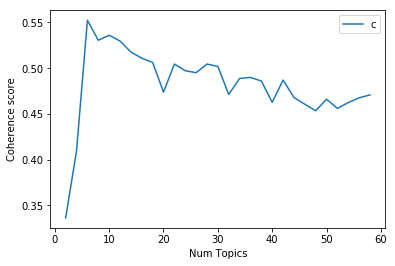

In [35]:
limit=60; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [36]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3364
Num Topics = 4  has Coherence Value of 0.4098
Num Topics = 6  has Coherence Value of 0.5524
Num Topics = 8  has Coherence Value of 0.5306
Num Topics = 10  has Coherence Value of 0.536
Num Topics = 12  has Coherence Value of 0.5297
Num Topics = 14  has Coherence Value of 0.5177
Num Topics = 16  has Coherence Value of 0.5109
Num Topics = 18  has Coherence Value of 0.5063
Num Topics = 20  has Coherence Value of 0.4738
Num Topics = 22  has Coherence Value of 0.5045
Num Topics = 24  has Coherence Value of 0.4973
Num Topics = 26  has Coherence Value of 0.4951
Num Topics = 28  has Coherence Value of 0.5045
Num Topics = 30  has Coherence Value of 0.502
Num Topics = 32  has Coherence Value of 0.4713
Num Topics = 34  has Coherence Value of 0.4888
Num Topics = 36  has Coherence Value of 0.4899
Num Topics = 38  has Coherence Value of 0.486
Num Topics = 40  has Coherence Value of 0.4627
Num Topics = 42  has Coherence Value of 0.487
Num Topics = 44  has 

In [39]:
optimal_model = model_list[8]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.016*"dossier" + 0.015*"2016" + 0.015*"intelligence" + 0.014*"information" '
  '+ 0.014*"steele" + 0.013*"fisa" + 0.012*"source" + 0.011*"page" + '
  '0.010*"document" + 0.010*"court"'),
 (1,
  '0.021*"yang" + 0.014*"royalwedding" + 0.009*"prince" + 0.008*"windsor" + '
  '0.007*"oscar" + 0.007*"harry" + 0.007*"tidak" + 0.006*"lie" + '
  '0.006*"sungai" + 0.006*"meghan"'),
 (2,
  '0.029*"trump" + 0.019*"pour" + 0.014*"mueller" + 0.013*"dans" + '
  '0.011*"avec" + 0.008*"nunes" + 0.008*"justice" + 0.007*"mais" + '
  '0.007*"breaking" + 0.007*"président"'),
 (3,
  '0.045*"vote" + 0.043*"2018" + 0.037*"candidate" + 0.031*"democratic" + '
  '0.019*"state" + 0.018*"november" + 0.017*"voting" + 0.016*"early" + '
  '0.016*"incumbent" + 0.015*"register"'),
 (4,
  '0.073*"trump" + 0.031*"russia" + 0.027*"russian" + 0.027*"mueller" + '
  '0.017*"campaign" + 0.017*"putin" + 0.014*"manafort" + 0.013*"flynn" + '
  '0.012*"meeting" + 0.012*"deal"'),
 (5,
  '0.066*"trump" + 0.014*"criminal" +

In [ ]:
"""dictionary = gensim.corpora.Dictionary.load(NDIC)
corpus = pickle.load(open(NCOR, 'rb'))
lda = gensim.models.ldamodel.LdaModel.load(NMOD)
import pyLDAvis.gensim"""

In [ ]:
"""lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)"""

# 